In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GroupedLinear(nn.Module):
    def __init__(self, in_dim, out_dim, num_groups=5, interconnect_ratio=0.1):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_groups = num_groups
        self.group_in = in_dim // num_groups
        self.group_out = out_dim // num_groups

        # 全結合行列（重み初期化）
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim) * (2 / in_dim) ** 0.5)
        self.bias = nn.Parameter(torch.zeros(out_dim))

        # マスク：グループ内接続 + ごく一部のランダムなグループ外接続
        self.mask = self.create_group_mask(interconnect_ratio)

    def create_group_mask(self, interconnect_ratio):
        mask = torch.zeros((self.out_dim, self.in_dim))
        for g_out in range(self.num_groups):
            for g_in in range(self.num_groups):
                if g_in == g_out:
                    # グループ内結合は全許可
                    mask[g_out*self.group_out:(g_out+1)*self.group_out,
                         g_in*self.group_in:(g_in+1)*self.group_in] = 1
                elif torch.rand(1).item() < interconnect_ratio:
                    # ランダムに長距離結合を許可
                    mask[g_out*self.group_out:(g_out+1)*self.group_out,
                         g_in*self.group_in:(g_in+1)*self.group_in] = 1
        return nn.Parameter(mask, requires_grad=False)

    def forward(self, x):
        masked_weight = self.weight * self.mask
        return F.linear(x, masked_weight, self.bias)

class BiologicalMLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, output_dim=10, num_groups=5):
        super().__init__()
        self.input_group = 0
        self.output_group = num_groups - 1

        self.fc1 = GroupedLinear(input_dim, hidden_dim, num_groups=num_groups, interconnect_ratio=0.05)
        self.fc2 = GroupedLinear(hidden_dim, hidden_dim, num_groups=num_groups, interconnect_ratio=0.05)
        self.fc3 = GroupedLinear(hidden_dim, output_dim, num_groups=num_groups, interconnect_ratio=0.0)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# データ準備
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_set = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_set  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64)

# モデル訓練
model = BiologicalMLP()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(model, loader, opt, epochs=5):
    model.train()
    for epoch in range(epochs):
        for x, y in loader:
            pred = model(x)
            loss = F.cross_entropy(pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()

def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            correct += (pred.argmax(1) == y).sum().item()
    return correct / len(loader.dataset)

train(model, train_loader, opt)
print("Test accuracy:", test(model, test_loader))


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.87MB/s]


Test accuracy: 0.8816


In [3]:
import networkx as nx

def model_to_graph(model):
    """BiologicalMLPを NetworkX のDiGraphに変換"""
    G = nx.DiGraph()
    node_id = 0
    node_map = []

    for layer in [model.fc1, model.fc2, model.fc3]:
        in_size = layer.in_dim
        out_size = layer.out_dim

        # ノード登録
        layer_in_nodes = list(range(node_id, node_id + in_size))
        node_id += in_size
        layer_out_nodes = list(range(node_id, node_id + out_size))
        node_id += out_size
        node_map.append((layer_in_nodes, layer_out_nodes))

        # マスクに基づいてエッジを張る
        mask = layer.mask.detach().cpu().numpy()
        for i, out_node in enumerate(layer_out_nodes):
            for j, in_node in enumerate(layer_in_nodes):
                if mask[i, j] > 0:
                    G.add_edge(in_node, out_node)

    return G


In [4]:
def analyze_graph(G):
    print(f"ノード数: {G.number_of_nodes()}, エッジ数: {G.number_of_edges()}")

    deg = nx.degree_centrality(G)
    btw = nx.betweenness_centrality(G)
    clustering = nx.clustering(G.to_undirected())  # 無向で評価
    try:
        largest_cc = max(nx.weakly_connected_components(G), key=len)
    except:
        largest_cc = []

    return {
        'degree': deg,
        'betweenness': btw,
        'clustering': clustering,
        'largest_cc_size': len(largest_cc),
        'graph': G
    }


In [6]:
def plot_graph(G, centrality, title="Graph"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    pos = nx.spring_layout(G, seed=42)
    node_size = [centrality[n] * 3000 for n in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=node_size, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_distributions(metrics):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.histplot(list(metrics['degree'].values()), bins=30, kde=True, ax=axes[0])
    axes[0].set_title("Degree Centrality Distribution")
    axes[0].set_xlabel("Degree Centrality")

    sns.histplot(list(metrics['betweenness'].values()), bins=30, kde=True, ax=axes[1])
    axes[1].set_title("Betweenness Centrality Distribution")
    axes[1].set_xlabel("Betweenness Centrality")

    sns.histplot(list(metrics['clustering'].values()), bins=30, kde=True, ax=axes[2])
    axes[2].set_title("Clustering Coefficient Distribution")
    axes[2].set_xlabel("Clustering Coefficient")

    plt.tight_layout()
    plt.show()


ノード数: 2390, エッジ数: 120160


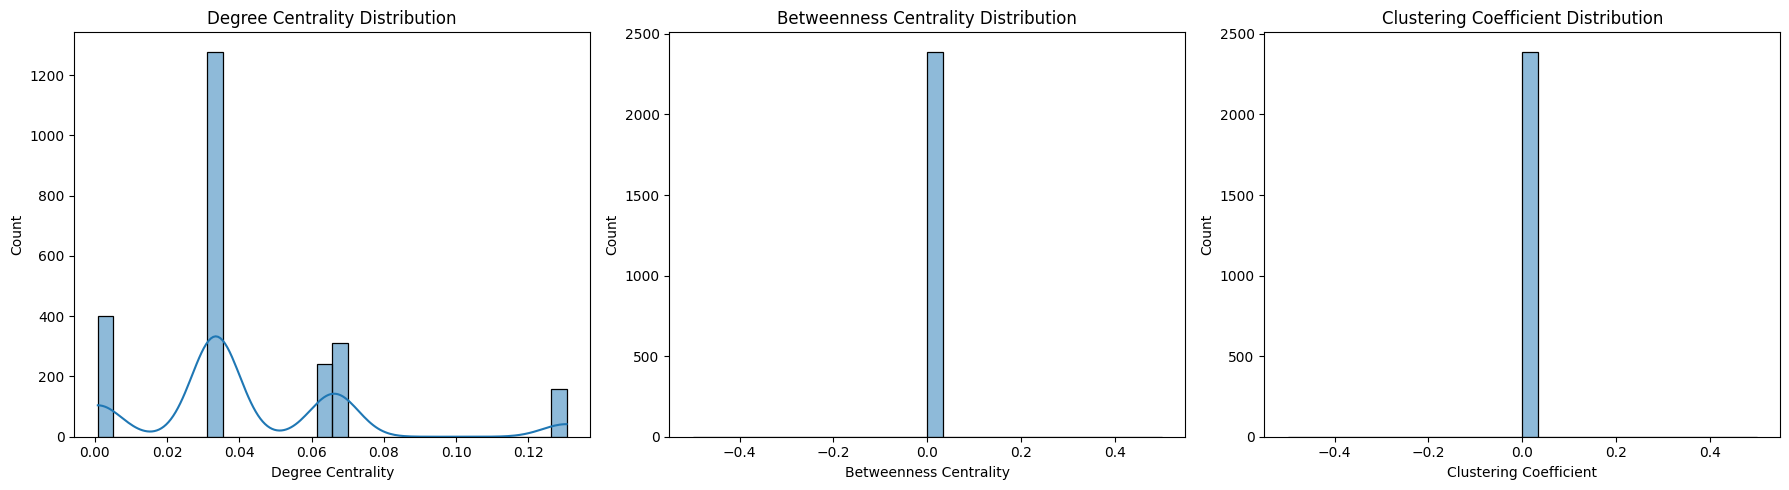

In [9]:
bio_model = BiologicalMLP()
G_bio = model_to_graph(bio_model)
metrics = analyze_graph(G_bio)

# 可視化：中心性でスケーリング
plot_metric_distributions(metrics)



In [10]:
import numpy as np

print("Degree 中央値:", np.median(list(metrics['degree'].values())))
print("Betweenness 中央値:", np.median(list(metrics['betweenness'].values())))
print("Clustering 中央値:", np.median(list(metrics['clustering'].values())))
print("最大連結成分ノード数:", metrics['largest_cc_size'])


Degree 中央値: 0.033486814566764334
Betweenness 中央値: 0.0
Clustering 中央値: 0.0
最大連結成分ノード数: 472


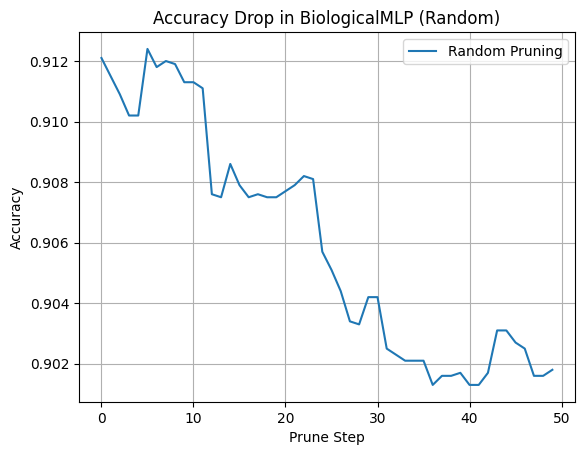

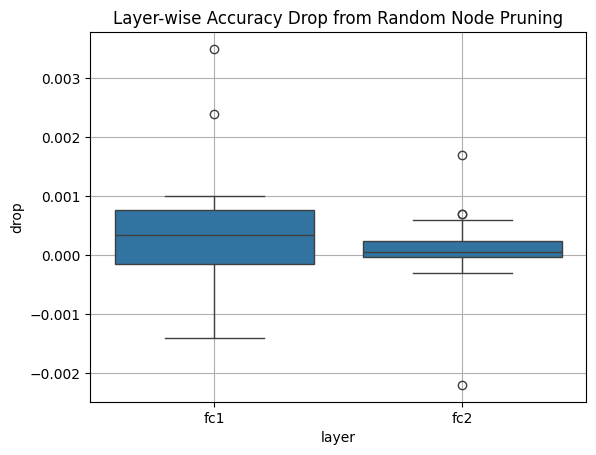

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import networkx as nx
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ====================== データ準備 ======================
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_set = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_set  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64)

# ====================== 生物風MLP ======================
class GroupedLinear(nn.Module):
    def __init__(self, in_dim, out_dim, num_groups=5, interconnect_ratio=0.05):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_groups = num_groups
        self.group_in = in_dim // num_groups
        self.group_out = out_dim // num_groups

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim) * (2 / in_dim) ** 0.5)
        self.bias = nn.Parameter(torch.zeros(out_dim))
        self.mask = self.create_group_mask(interconnect_ratio)

    def create_group_mask(self, interconnect_ratio):
        mask = torch.zeros((self.out_dim, self.in_dim))
        for g_out in range(self.num_groups):
            for g_in in range(self.num_groups):
                if g_in == g_out or torch.rand(1).item() < interconnect_ratio:
                    mask[g_out*self.group_out:(g_out+1)*self.group_out,
                         g_in*self.group_in:(g_in+1)*self.group_in] = 1
        return nn.Parameter(mask, requires_grad=False)

    def forward(self, x):
        masked_weight = self.weight * self.mask
        return F.linear(x, masked_weight, self.bias)

class BiologicalMLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, output_dim=10, num_groups=5):
        super().__init__()
        self.fc1 = GroupedLinear(input_dim, hidden_dim, num_groups=num_groups)
        self.fc2 = GroupedLinear(hidden_dim, hidden_dim, num_groups=num_groups)
        self.fc3 = GroupedLinear(hidden_dim, output_dim, num_groups=num_groups)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ====================== 学習・評価 ======================
def train(model, loader, opt, epochs=1):
    model.train()
    for _ in range(epochs):
        for x, y in loader:
            pred = model(x)
            loss = F.cross_entropy(pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()

def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            correct += (pred.argmax(1) == y).sum().item()
    return correct / len(loader.dataset)

# ====================== ノード削除 ======================
def prune_node(model, layer_name, neuron_idx):
    layer = getattr(model, layer_name)
    if layer.out_dim <= 1: return

    with torch.no_grad():
        # 出力側削除
        layer.weight = nn.Parameter(torch.cat([layer.weight[:neuron_idx], layer.weight[neuron_idx + 1:]], dim=0))
        layer.bias = nn.Parameter(torch.cat([layer.bias[:neuron_idx], layer.bias[neuron_idx + 1:]], dim=0))
        layer.mask = nn.Parameter(torch.cat([layer.mask[:neuron_idx], layer.mask[neuron_idx + 1:]], dim=0), requires_grad=False)
        layer.out_dim -= 1
        layer.group_out = layer.out_dim // layer.num_groups

        # 次の層の入力側（列）も削除
        next_layer = None
        if layer_name == 'fc1':
            next_layer = model.fc2
        elif layer_name == 'fc2':
            next_layer = model.fc3

        if next_layer is not None:
            next_layer.weight = nn.Parameter(torch.cat([
                next_layer.weight[:, :neuron_idx],
                next_layer.weight[:, neuron_idx + 1:]
            ], dim=1))
            next_layer.in_dim -= 1
            next_layer.group_in = next_layer.in_dim // next_layer.num_groups
            next_layer.mask = nn.Parameter(torch.cat([
                next_layer.mask[:, :neuron_idx],
                next_layer.mask[:, neuron_idx + 1:]
            ], dim=1), requires_grad=False)


def prune_random_nodes(model, test_loader, max_steps=50):
    model = copy.deepcopy(model)
    history = []
    for step in range(max_steps):
        layer_name = random.choice(['fc1', 'fc2'])
        layer = getattr(model, layer_name)
        if layer.out_dim <= 1: continue
        neuron_idx = random.randint(0, layer.out_dim - 1)
        acc_before = test(model, test_loader)
        prune_node(model, layer_name, neuron_idx)
        acc_after = test(model, test_loader)
        history.append({'step': step, 'layer': layer_name, 'neuron': neuron_idx,
                        'acc_before': acc_before, 'acc_after': acc_after, 'drop': acc_before - acc_after})
    return pd.DataFrame(history)


# ====================== 実行 ======================
model = BiologicalMLP()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, train_loader, opt, epochs=5)
df_rand = prune_random_nodes(model, test_loader)

# ====================== 可視化 ======================
plt.plot(df_rand['step'], df_rand['acc_after'], label="Random Pruning")
plt.xlabel("Prune Step")
plt.ylabel("Accuracy")
plt.title("Accuracy Drop in BiologicalMLP (Random)")
plt.grid(True)
plt.legend()
plt.show()

sns.boxplot(data=df_rand, x='layer', y='drop')
plt.title("Layer-wise Accuracy Drop from Random Node Pruning")
plt.grid(True)
plt.show()


In [23]:
# ====================== グラフ変換 ======================
def model_to_graph(model):
    G = nx.DiGraph()
    node_id = 0
    node_map = []

    for layer in [model.fc1, model.fc2, model.fc3]:
        in_size = layer.in_dim
        out_size = layer.out_dim
        layer_in_nodes = list(range(node_id, node_id + in_size))
        node_id += in_size
        layer_out_nodes = list(range(node_id, node_id + out_size))
        node_id += out_size
        node_map.append((layer_in_nodes, layer_out_nodes))
        mask = layer.mask.detach().cpu().numpy()
        for i, out_node in enumerate(layer_out_nodes):
            for j, in_node in enumerate(layer_in_nodes):
                if mask[i, j] > 0:
                    G.add_edge(in_node, out_node)
    return G, node_map

# ====================== 中心性スコアによるノード削除 ======================
def prune_by_centrality(model, G, node_map, centrality_dict, top_k=50, reverse=True, test_loader=None):
    model = copy.deepcopy(model)
    node_to_layer = {}
    for idx, (ins, outs) in enumerate(node_map[:2]):  # fc1, fc2 の出力ノードのみ対象
        for i, node in enumerate(outs):
            node_to_layer[node] = (['fc1', 'fc2'][idx], i)

    sorted_nodes = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=reverse)
    history = []
    for step, (node, _) in enumerate(sorted_nodes):
        if node not in node_to_layer:
            continue
        layer_name, local_idx = node_to_layer[node]
        layer = getattr(model, layer_name)
        if local_idx >= layer.out_dim:
            continue
        acc_before = test(model, test_loader)
        prune_node(model, layer_name, local_idx)  # 🔧 修正点
        acc_after = test(model, test_loader)
        history.append({
            'step': step,
            'layer': layer_name,
            'node': node,
            'local_idx': local_idx,
            'acc_before': acc_before,
            'acc_after': acc_after,
            'drop': acc_before - acc_after
        })
        if step + 1 >= top_k:
            break
    return pd.DataFrame(history)


# ====================== 実行（中心性順） ======================
model = BiologicalMLP()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, train_loader, opt, epochs=5)
G, node_map = model_to_graph(model)

deg = nx.degree_centrality(G)
btw = nx.betweenness_centrality(G)


# 高中心性から削除
df_deg_high = prune_by_centrality(model, G, node_map, deg, top_k=50, reverse=True, test_loader=test_loader)

# 低中心性から削除
df_deg_low = prune_by_centrality(model, G, node_map, deg, top_k=50, reverse=False, test_loader=test_loader)
df_btw_high = prune_by_centrality(model, G, node_map, btw,  top_k=50, reverse=True, test_loader=test_loader)
df_btw_low  = prune_by_centrality(model, G, node_map, btw,  top_k=50, reverse=False, test_loader=test_loader)


# ====================== 再学習による回復評価 ======================
def prune_and_retrain(model, layer_name='fc2', neuron_idxs=None, retrain_epochs=1, test_loader=None):
    model = copy.deepcopy(model)
    accs = []
    for step, idx in enumerate(neuron_idxs):
        layer = getattr(model, layer_name)
        if idx >= layer.out_dim:
            continue
        acc_before = test(model, test_loader)
        prune_node(model, layer_name, idx)  # 🔧 修正：modelとlayer_nameを渡す
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        train(model, train_loader, optimizer, epochs=retrain_epochs)
        acc_after = test(model, test_loader)
        accs.append({
            'step': step,
            'layer': layer_name,
            'neuron_idx': idx,
            'acc_before': acc_before,
            'acc_after': acc_after,
            'drop': acc_before - acc_after
        })
    return pd.DataFrame(accs)


neuron_idxs = list(range(0, 10))
df_recover = prune_and_retrain(model, layer_name='fc2', neuron_idxs=neuron_idxs, retrain_epochs=1, test_loader=test_loader)


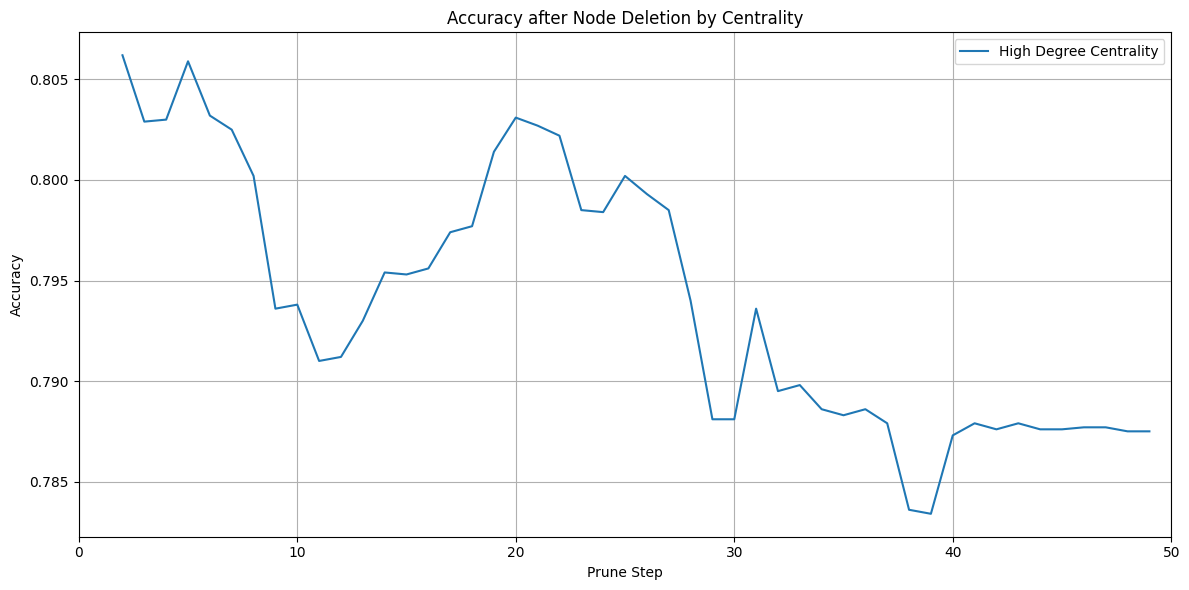

In [34]:
plt.figure(figsize=(12, 6))

plt.plot(df_deg_high['step'], df_deg_high['acc_after'], label='High Degree Centrality')
#plt.plot(df_deg_low['step'], df_deg_low['acc_after'], label='Low Degree Centrality')
#plt.plot(df_btw_high['step'], df_btw_high['acc_after'], label='High Betweenness Centrality')
#plt.plot(df_btw_low['step'], df_btw_low['acc_after'], label='Low Betweenness Centrality')
#plt.plot(df_recover['step'], df_recover['acc_after'], label='Retrain after Deletion', linestyle='--')
plt.xlabel('Prune Step')
plt.xlim(0, 50)
plt.ylabel('Accuracy')
plt.title('Accuracy after Node Deletion by Centrality')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
model = BiologicalMLP()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, train_loader, opt, epochs=5)
G, node_map = model_to_graph(model)

# グループ単位の集団死（例：group 0, 4）
df_block_0 = prune_group_block(model, group_id=0, layer_name='fc2', block_size=10, test_loader=test_loader)
df_block_4 = prune_group_block(model, group_id=4, layer_name='fc2', block_size=10, test_loader=test_loader)

# 密結合小集団（dense subgraph）による損傷
df_dense = prune_dense_subgraph(model, G, node_map, layer_name='fc2', k=10, test_loader=test_loader)


KeyboardInterrupt: 

In [ ]:
plt.plot(df_block_0['step'], df_block_0['acc_after'], label="Group 0 Block")
plt.plot(df_block_4['step'], df_block_4['acc_after'], label="Group 4 Block")
plt.plot(df_dense['step'], df_dense['acc_after'], label="Dense Subgraph")
plt.xlabel("Prune Step")
plt.ylabel("Accuracy")
plt.title("Accuracy Drop by Regional Cell Death")
plt.legend()
plt.grid(True)
plt.show()
